In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import os
import sys
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import MousePosition, ScrollZoomToggler, HeatMap
import pysal.lib.weights as sw # create spatial weights matrix
from pysal.explore.esda import Moran, Moran_Local #global & local Moran's I
from pysal.model import spreg #spatial regression module
from pysal.viz.splot.esda import lisa_cluster, plot_local_autocorrelation
# Spatial hex bin tools
import h3
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

# Suppress warnings and adjust settings
import warnings
warnings.filterwarnings('ignore') # Suppress Jupyter Notebook warnings
from IPython.core.display import display, HTML # Set HTML notebooks to max width
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 250)

"Load Complete"

C:\Users\Impul\.conda\envs\geo-ds\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Impul\.conda\envs\geo-ds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


'Load Complete'

In [6]:
# Previously geocoded address GEOJSON file
geo = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\appeals_sf.geojson")
# Geocoded addresses file 1
pro1 = gpd.read_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded1.shp')
# Geocoded addresses file 2
# pro2 = gpd.read_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded2.shp')

# MD Census Block Shapefile
md_blocks = gpd.read_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\MD_blck_grp_2019.shp')
md_blocks = md_blocks.to_crs(epsg=4326)

# Concatonate the 3 GeoDataFrames and save the results
# geocoded_final = gpd.GeoDataFrame(pd.concat([geo, pro1, pro2], ignore_index=True))

# Save final Geocoded GDF
# geocoded_final.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_final.shp')
# geocoded_final.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_final.geojson', driver='GeoJSON')

## SUMMARY PLOT

Text(0.5, 0.98, '% change plotted over MD census blocks')

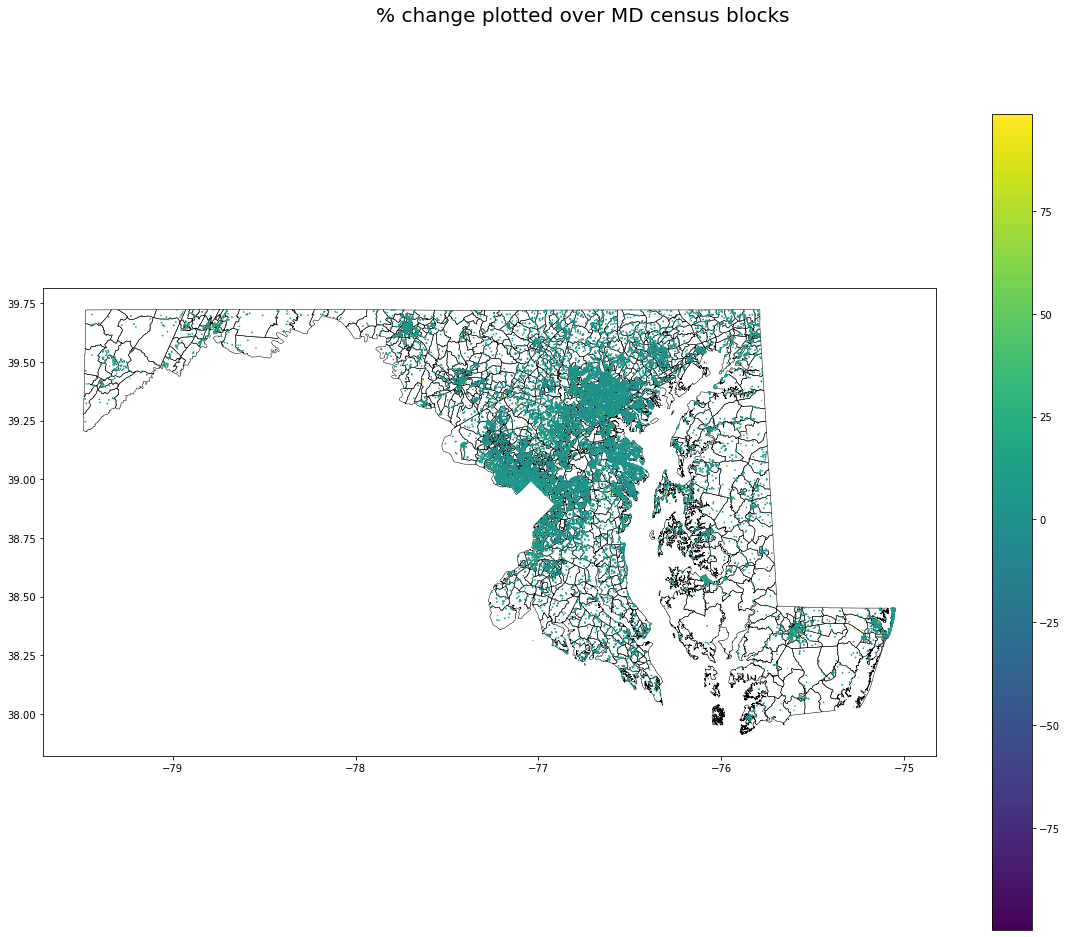

In [8]:
# Overall situation plot
fig, ax = plt.subplots(figsize=(20,15))
md_blocks.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5)
# Filtering out rows that have > 100% change in appraisal value, + or -
geoprocessed_mask = ((geo['pct_change'] < 100.0) & (geo['pct_change'] > -100.0)) #  & (joined['pct_change'] != 0.0)
geoprocessed_filter = geo[geoprocessed_mask]
geoprocessed_filter.plot('pct_change', markersize=0.5, ax=ax, legend=True)
fig.suptitle("% change plotted over MD census blocks", fontsize=20)

## GEOCODING

In [ ]:
import pprint
from opencage.geocoder import OpenCageGeocode
geoCoder = OpenCageGeocode("fc354e502182441aad194782b3a03043")
# Read in data
df_to_geoloc = gpd.read_file(r"maryland_tax_valuations\data\processed\appeals_rvals_matched.csv")

In [ ]:
# Create mask of ungeocoded addresses
mask = df_to_geoloc['match_address'] == 'NA' # 3724 addresses unsuccessfully geocoded
mask.value_counts()

In [ ]:
unpro_filter = df_to_geoloc[mask]
len(unpro_filter)

In [ ]:
# Subsetting first query
pro1 = unpro_filter[:2300]

addresses = pro1["address_correct"].values.tolist()
latitudes = []
longitudes = []

# Geocoding query 1
for address in addresses:
    result = geoCoder.geocode(address)
    if result and len(result):
        longitudes.append(result[0]["geometry"]["lng"])
        latitudes.append(result[0]["geometry"]["lat"])
    else:
        longitudes.append(None)
        latitudes.append(None)

pro1['geometry'] = gpd.points_from_xy(latitudes, longitudes)
pro1

In [ ]:
# Save work
pro1.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded1.shp')
pro1.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded1.geojson', driver='GeoJSON')

In [ ]:
# Subsetting second query
pro2 = unpro_filter[2300:]

addresses = pro2["address_correct"].values.tolist()
latitudes = []
longitudes = []

# Geocoding query 2
for address in addresses:
    result = geoCoder.geocode(address)
    if result and len(result):
        longitudes.append(result[0]["geometry"]["lng"])
        latitudes.append(result[0]["geometry"]["lat"])
    else:
        longitudes.append(None)
        latitudes.append(None)

pro2['geometry'] = gpd.points_from_xy(latitudes, longitudes)
pro2

In [ ]:
# Save work
pro2.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded2.shp')
pro2.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded2.geojson', driver='GeoJSON')